In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/msk-redefining-cancer-treatment/training_text.zip
/kaggle/input/msk-redefining-cancer-treatment/stage2_test_variants.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage1_solution_filtered.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage2_test_text.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/test_text.zip
/kaggle/input/msk-redefining-cancer-treatment/test_variants.zip
/kaggle/input/msk-redefining-cancer-treatment/stage2_sample_submission.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage_2_private_solution.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/training_variants.zip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
data = pd.read_csv('../input/msk-redefining-cancer-treatment/training_variants.zip')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
# note the seprator in this file
data_text =pd.read_csv("../input/msk-redefining-cancer-treatment/training_text.zip",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [9]:
#text processing stage.
start_time = time.clock()
for index,row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 57.113302 seconds


In [10]:
df = pd.merge(data,data_text,on = 'ID', how = 'left')
df.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [11]:
df.loc[(df.TEXT.isnull()),'TEXT'] = df['Gene'] + df['Variation']

In [12]:
df[df['ID'] == 1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCAS1088F


In [13]:
y = df['Class']

In [14]:
df.Gene = df.Gene.str.replace('\s+', '_')
df.Variation = df.Variation.str.replace('\s+', '_')

In [15]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
x_train, x_test, y_train, y_test = train_test_split(df, y, stratify=y, test_size=0.2)

In [16]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2656, 5)
(665, 5)
(2656,)
(665,)


In [17]:
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2)

In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_cv.shape)
print(y_cv.shape)

(2124, 5)
(2124,)
(665, 5)
(665,)
(532, 5)
(532,)


In [19]:
train_class = (x_train.Class.value_counts().sort_index())
test_class = (x_test.Class.value_counts().sort_index())
cv_class = (x_cv.Class.value_counts().sort_index())

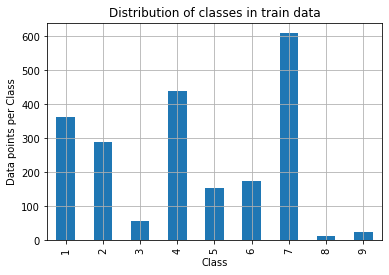

****************************************************************************************************


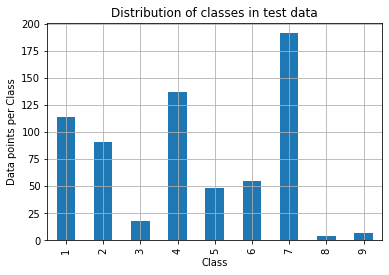

****************************************************************************************************


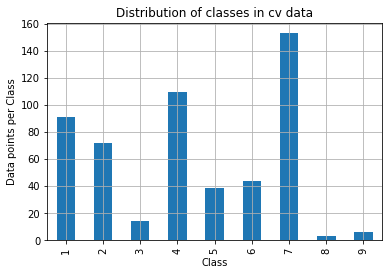

****************************************************************************************************


In [20]:
my_colors = 'rgbkymc'
train_class.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of classes in train data')
plt.grid()
plt.show()

print('*'* 100)

my_colors = 'rgbkymc'
test_class.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of classes in test data')
plt.grid()
plt.show()

print('*'* 100)

my_colors = 'rgbkymc'
cv_class.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of classes in cv data')
plt.grid()
plt.show()

print('*'* 100)

In [21]:
#This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

# Univariate Analysis

In [22]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = x_train[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # i - Gene/variant name and denominator = num of time feature occured.
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 dimensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            #cls_cnt contins the dataframe with class = k and feature = i
            cls_cnt = x_train.loc[(x_train['Class']==k) & (x_train[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = x_train[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

### Univariate Analysis on Gene feature

In [23]:
unique_genes = x_train['Gene'].value_counts()
print("Total number of unique genes are:", unique_genes.shape[0])
print(unique_genes.head())

Total number of unique genes are: 237
BRCA1    158
TP53      96
EGFR      95
PTEN      81
BRCA2     77
Name: Gene, dtype: int64


In [24]:
type(unique_genes)

pandas.core.series.Series

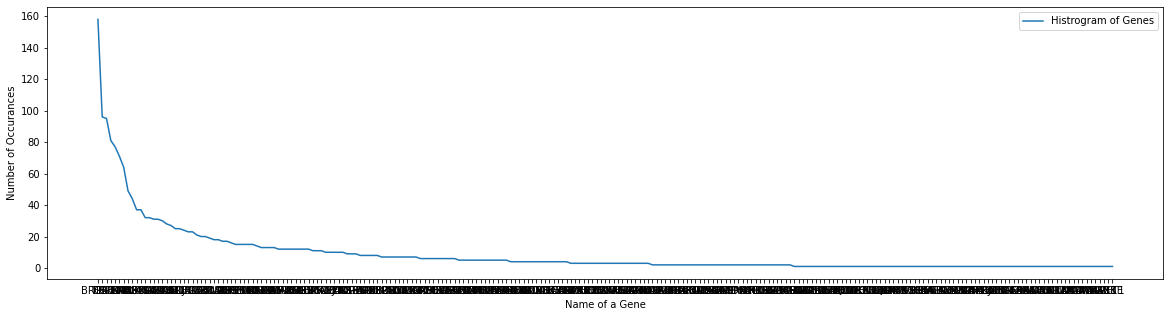

In [25]:
plt.figure(figsize=(20, 5))
plt.plot(unique_genes, label="Histrogram of Genes")
plt.xlabel('Name of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
#plt.grid()
plt.show()

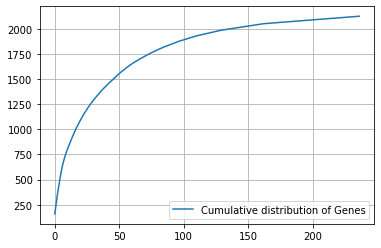

In [26]:
c = np.cumsum(unique_genes.values)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [27]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_response = np.array(get_gv_feature(alpha, "Gene", x_train))
# test gene feature
test_gene_response = np.array(get_gv_feature(alpha, "Gene", x_test))
# cross validation gene feature
cv_gene_response = np.array(get_gv_feature(alpha, "Gene", x_cv))

In [28]:
print("train_gene_response is converted feature using respone coding method. The shape of gene feature:", train_gene_response.shape)

train_gene_response is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [29]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_onehotCoding = gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_onehotCoding = gene_vectorizer.transform(x_test['Gene'])
cv_gene_onehotCoding = gene_vectorizer.transform(x_cv['Gene'])

In [30]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'axin1',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hras',
 

In [31]:
print("train_gene_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_onehotCoding.shape)

train_gene_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 236)


In [32]:
from sklearn.calibration import CalibratedClassifierCV

For alpha = 1e-05 the log-loss is 1.1971463976576227
For alpha = 0.0001 the log-loss is 1.1674693652666321
For alpha = 0.001 the log-loss is 1.2058761397043543
For alpha = 0.01 the log-loss is 1.3284570755579133
For alpha = 0.1 the log-loss is 1.434415486897696
For alpha = 1 the log-loss is 1.4709704250591173


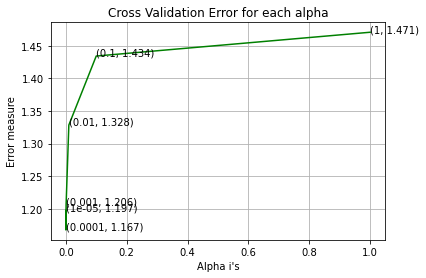

For values of best alpha =  0.0001 The train log loss is: 1.0044867370337238
For values of best alpha =  0.0001 The cross validation log loss is: 1.1674693652666321
For values of best alpha =  0.0001 The test log loss is: 1.1476351710869384


In [33]:
alpha = [10 ** x for x in range(-5,1)]

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(loss = 'log', penalty = 'l2', alpha = i, random_state = 42)
    clf.fit(train_gene_onehotCoding,y_train)
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_gene_onehotCoding,y_train)
    predict_y = sig_clf.predict_proba(cv_gene_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv,predict_y,labels = clf.classes_))
    print("For alpha =",i,"the log-loss is",log_loss(y_cv,predict_y,labels = clf.classes_))

fig,ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show() 

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(loss = 'log', penalty = 'l2', alpha = alpha[best_alpha], random_state = 42)
clf.fit(train_gene_onehotCoding,y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_gene_onehotCoding,y_train)
    
    
predict_y = sig_clf.predict_proba(train_gene_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train,predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv,predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test,predict_y, labels=clf.classes_,eps=1e-15))

In [34]:
print("Number of data points in Test and CV datasets covered by", unique_genes.shape[0],"genes in train dataset")

test_coverage = x_test[x_test['Gene'].isin(list(set(x_train['Gene'])))].shape[0]
cv_coverage = x_cv[x_cv['Gene'].isin(list(set(x_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',x_test.shape[0], ":",(test_coverage/x_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',x_cv.shape[0],":" ,(cv_coverage/x_cv.shape[0])*100)

Number of data points in Test and CV datasets covered by 237 genes in train dataset
Ans
1. In test data 651 out of 665 : 97.89473684210527
2. In cross validation data 514 out of  532 : 96.61654135338345


### Univariate Analysis on Variantion feature

In [35]:
unique_variations = x_train['Variation'].value_counts()
print("Total number of unique Variations are:", unique_variations.shape[0])
print(unique_variations.head())

Total number of unique Variations are: 1907
Truncating_Mutations    69
Amplification           55
Deletion                48
Fusions                 19
Overexpression           3
Name: Variation, dtype: int64


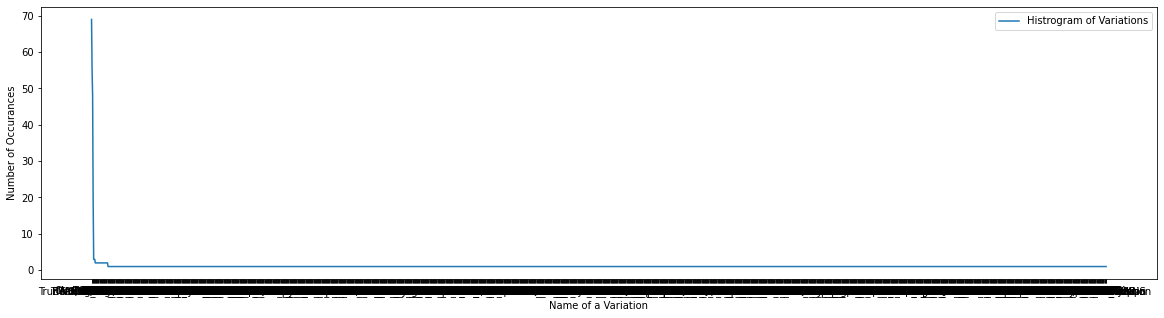

In [36]:
plt.figure(figsize=(20, 5))
plt.plot(unique_variations, label="Histrogram of Variations")
plt.xlabel('Name of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
#plt.grid()
plt.show()

Truncating_Mutations      69
Amplification            124
Deletion                 172
Fusions                  191
Overexpression           194
                        ... 
E996K                   2120
S45Y                    2121
D254N                   2122
R342Q                   2123
E3002K                  2124
Name: Variation, Length: 1907, dtype: int64


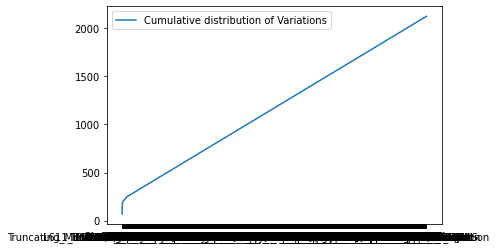

In [37]:
c = np.cumsum(unique_variations)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
#plt.grid()
plt.legend()
plt.show()

In [38]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_response = np.array(get_gv_feature(alpha, "Variation", x_train))
# test gene feature
test_variation_response = np.array(get_gv_feature(alpha, "Variation", x_test))
# cross validation gene feature
cv_variation_response = np.array(get_gv_feature(alpha, "Variation", x_cv))

In [39]:
print("train_variation_response is converted feature using respone coding method. The shape of variation feature:", train_variation_response.shape)

train_variation_response is converted feature using respone coding method. The shape of variation feature: (2124, 9)


In [40]:
# one-hot encoding of Gene feature.
var_vectorizer = CountVectorizer()
train_variation_onehotCoding = var_vectorizer.fit_transform(x_train['Variation'])
test_variation_onehotCoding = var_vectorizer.transform(x_test['Variation'])
cv_variation_onehotCoding = var_vectorizer.transform(x_cv['Variation'])

In [41]:
print("train_variation_onehotCoding is converted feature using one-hot encoding method. The shape of variation feature:", train_variation_onehotCoding.shape)

train_variation_onehotCoding is converted feature using one-hot encoding method. The shape of variation feature: (2124, 1939)


For alpha = 1e-05 the log-loss is 1.7347572100072426
For alpha = 0.0001 the log-loss is 1.7317418075755768
For alpha = 0.001 the log-loss is 1.7362358437299552
For alpha = 0.01 the log-loss is 1.745315510736588
For alpha = 0.1 the log-loss is 1.7468003515407742
For alpha = 1 the log-loss is 1.7480123110453287


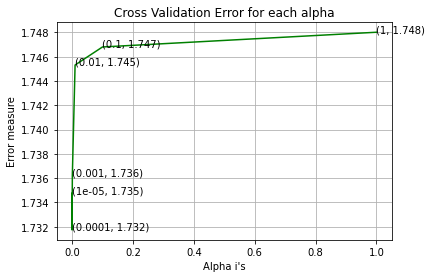

For values of best alpha =  0.0001 The train log loss is: 0.6872730504944645
For values of best alpha =  0.0001 The cross validation log loss is: 1.7317418075755768
For values of best alpha =  0.0001 The test log loss is: 1.7125339646975908


In [42]:
alpha = [10 ** x for x in range(-5,1)]

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(loss = 'log', penalty = 'l2', alpha = i, random_state = 42)
    clf.fit(train_variation_onehotCoding,y_train)
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_variation_onehotCoding,y_train)
    predict_y = sig_clf.predict_proba(cv_variation_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv,predict_y,labels = clf.classes_))
    print("For alpha =",i,"the log-loss is",log_loss(y_cv,predict_y,labels = clf.classes_))

fig,ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show() 

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(loss = 'log', penalty = 'l2', alpha = alpha[best_alpha], random_state = 42)
clf.fit(train_variation_onehotCoding,y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_variation_onehotCoding,y_train)
    
    
predict_y = sig_clf.predict_proba(train_variation_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train,predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv,predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test,predict_y, labels=clf.classes_,eps=1e-15))

In [43]:
print("Number of data points in Test and CV datasets covered by", unique_variations.shape[0],"genes in train dataset")

test_coverage = x_test[x_test['Variation'].isin(list(set(x_train['Variation'])))].shape[0]
cv_coverage = x_cv[x_cv['Variation'].isin(list(set(x_train['Variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',x_test.shape[0], ":",(test_coverage/x_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',x_cv.shape[0],":" ,(cv_coverage/x_cv.shape[0])*100)

Number of data points in Test and CV datasets covered by 1907 genes in train dataset
Ans
1. In test data 54 out of 665 : 8.1203007518797
2. In cross validation data 47 out of  532 : 8.834586466165414


# Univariate Analysis on Text Feature

In [44]:
x_test.head()

,ID,Gene,Variation,Class,TEXT
366,366,EPAS1,Y532C,2,introduction hypoxia inducible factors hifs ce...
263,263,EGFR,R776C,7,purpose epidermal growth factor receptor egfr ...
1074,1074,FOXA1,S453fs*,2,characterization prostate cancer transcriptome...
2174,2174,PTEN,R173C,4,tumor suppressor gene pten frequently mutated ...
1944,1944,CARD11,D401N,7,diffuse large b cell lymphoma dlbcl complex di...


In [45]:
# cls_text is a data frame
# for every row in data frame consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

#In a nutshell, this function returns a dictionary with key : word and value : count of word in that dataframe.
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [46]:
#dictionary of dictionaries
dict_list = []       
# dict_list =[] contains 9 dictionaries each corresponds to a class
for i in range(1,10):
    cls_text = x_train[x_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list


In [47]:
#we calculate total number of words present in each class
total_words_inclass_dict = defaultdict(int)
for i in range(1,10):
    txt = x_train[x_train['Class'] == i]
    for index,row in txt.iterrows():
        for word in row['TEXT'].split():
            total_words_inclass_dict[i] += 1

In [48]:
total_words_inclass_dict

defaultdict(int,
            {1: 2495149,
             2: 1954406,
             3: 253511,
             4: 2787186,
             5: 843232,
             6: 904732,
             7: 5115708,
             8: 96099,
             9: 243524})

In [49]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_words_inclass_dict[i+1]+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [50]:
#response coding of text features
train_text_response = get_text_responsecoding(x_train)
test_text_response = get_text_responsecoding(x_test)
cv_text_response = get_text_responsecoding(x_cv)

In [51]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_bow = text_vectorizer.fit_transform(x_train['TEXT'])


In [52]:
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_bow.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
# .A1 returns a flattened ndarray
train_text_feature_counts = train_text_bow.sum(axis=0).A1

print(train_text_feature_counts)
# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_feature_counts))


print("Total number of unique words in train data :", len(train_text_features))

[2480 5769    5 ...    8    6   13]
Total number of unique words in train data : 53809


In [53]:
# we use the same vectorizer that was trained on train data
test_text_bow = text_vectorizer.transform(x_test['TEXT'])

# we use the same vectorizer that was trained on train data
cv_text_bow = text_vectorizer.transform(x_cv['TEXT'])

For values of alpha =  1e-05 The log loss is: 1.8308894970074716
For values of alpha =  0.0001 The log loss is: 1.7818063336525365
For values of alpha =  0.001 The log loss is: 1.3342770995953894
For values of alpha =  0.01 The log loss is: 1.328258128882572
For values of alpha =  0.1 The log loss is: 1.318018303468554
For values of alpha =  1 The log loss is: 1.239261987808892


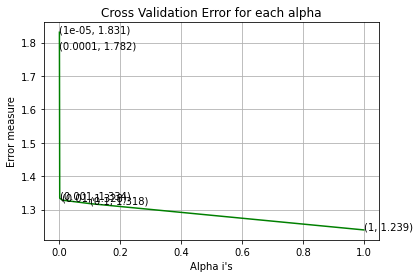

For values of best alpha =  1 The train log loss is: 0.7825009183535467
For values of best alpha =  1 The cross validation log loss is: 1.239261987808892
For values of best alpha =  1 The test log loss is: 1.1398743547072332


In [54]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_bow, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_bow, y_train)
    predict_y = sig_clf.predict_proba(cv_text_bow)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_bow, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_bow, y_train)

predict_y = sig_clf.predict_proba(train_text_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [55]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [56]:
len1,len2 = get_intersec_text(x_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(x_cv)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.153 % of word of test data appeared in train data
98.007 % of word of Cross Validation appeared in train data


In [57]:
#Data preparation for ML models.

#Misc. functionns for ML models

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [58]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

Stacking the three features

In [59]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_onehotCoding,train_variation_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_onehotCoding,test_variation_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_onehotCoding,cv_variation_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_bow)).tocsr()
train_y = np.array(list(x_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_bow)).tocsr()
test_y = np.array(list(x_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_bow)).tocsr()
cv_y = np.array(list(x_cv['Class']))

In [60]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55984)
(number of data points * number of features) in test data =  (665, 55984)
(number of data points * number of features) in cross validation data = (532, 55984)


In [61]:
train_gene_var_responseCoding = np.hstack((train_gene_response,train_variation_response))
test_gene_var_responseCoding = np.hstack((test_gene_response,test_variation_response))
cv_gene_var_responseCoding = np.hstack((cv_gene_response,cv_variation_response))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_response))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_response))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_response))

In [62]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## Baseline models
### 1.Naive Bayes

for alpha = 1e-05
Log Loss : 1.2914624118699498
for alpha = 0.0001
Log Loss : 1.299949673852395
for alpha = 0.001
Log Loss : 1.303388300611376
for alpha = 0.1
Log Loss : 1.3081471892567142
for alpha = 1
Log Loss : 1.301563079455017
for alpha = 10
Log Loss : 1.3741026379559278
for alpha = 100
Log Loss : 1.693248196905661
for alpha = 1000
Log Loss : 1.8044139599298543


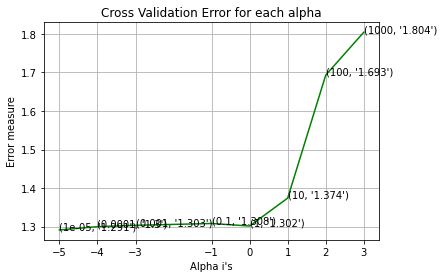

For values of best alpha =  1e-05 The train log loss is: 0.9451849105839925
For values of best alpha =  1e-05 The cross validation log loss is: 1.2914624118699498
For values of best alpha =  1e-05 The test log loss is: 1.2359689010698138


In [63]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)): 
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.2914624118699498
Number of missclassified point : 0.39849624060150374
-------------------- Confusion matrix --------------------


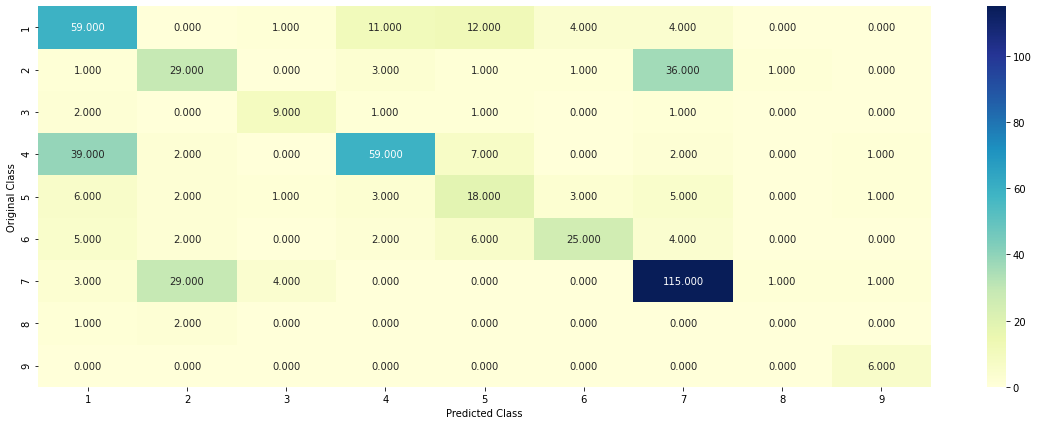

-------------------- Precision matrix (Columm Sum=1) --------------------


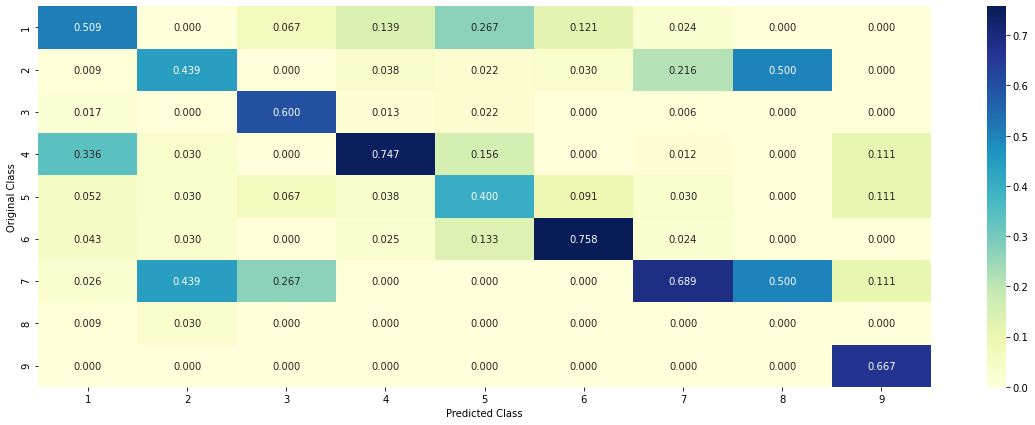

-------------------- Recall matrix (Row sum=1) --------------------


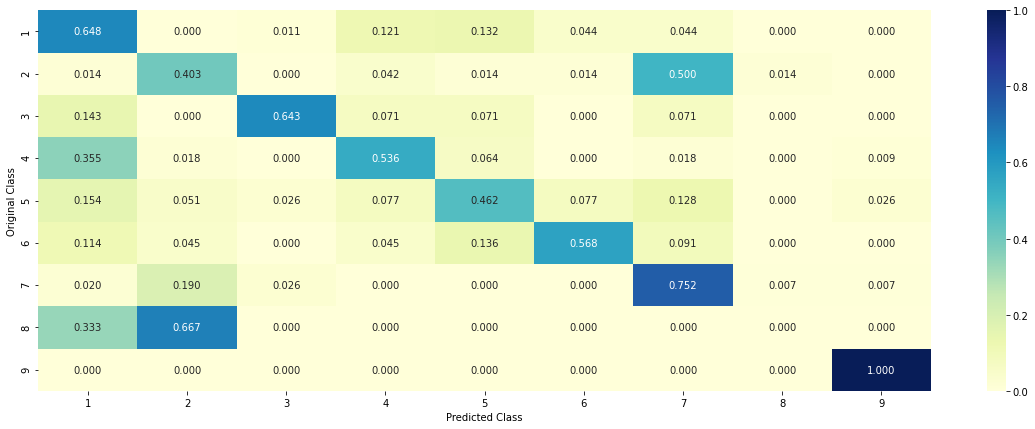

In [64]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y) 
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [65]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[0.565  0.0931 0.0162 0.1233 0.0445 0.0438 0.1037 0.0059 0.0046]]
Actual Class : 1


In [66]:
test_point_index = 90
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.0877 0.1801 0.0155 0.1168 0.0417 0.0415 0.5068 0.0057 0.0042]]
Actual Class : 3


### 2. K-Nearest Neighbours

for neighbours = 5
Log Loss : 1.2438747703080566
for neighbours = 11
Log Loss : 1.1951569831597952
for neighbours = 15
Log Loss : 1.1674062686524287
for neighbours = 21
Log Loss : 1.1335274815040304
for neighbours = 31
Log Loss : 1.1283454729007938
for neighbours = 41
Log Loss : 1.117655857783124
for neighbours = 51
Log Loss : 1.1072393494241974
for neighbours = 99
Log Loss : 1.1430628054524326


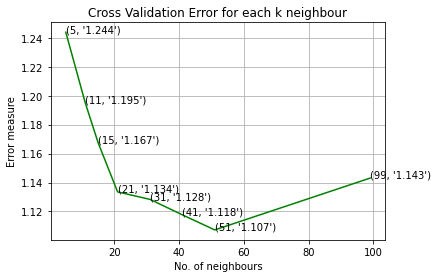

For values of best alpha =  51 The train log loss is: 0.7878569261956531
For values of best alpha =  51 The cross validation log loss is: 1.1072393494241974
For values of best alpha =  51 The test log loss is: 1.1308565877187158


In [67]:
k = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in k:
    print("for neighbours =", i)
    clf = KNeighborsClassifier(n_neighbors=i,)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(k, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((k[i],str(txt)), (k[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each k neighbour")
plt.xlabel("No. of neighbours")
plt.ylabel("Error measure")
plt.show()


best_k = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors = k[best_k])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', k[best_k], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', k[best_k], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', k[best_k], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1072393494241974
Number of mis-classified points : 0.40789473684210525
-------------------- Confusion matrix --------------------


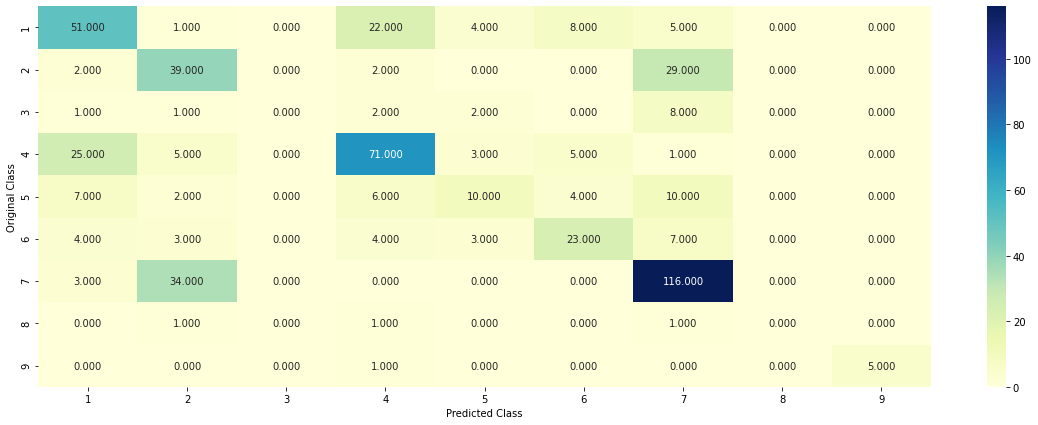

-------------------- Precision matrix (Columm Sum=1) --------------------


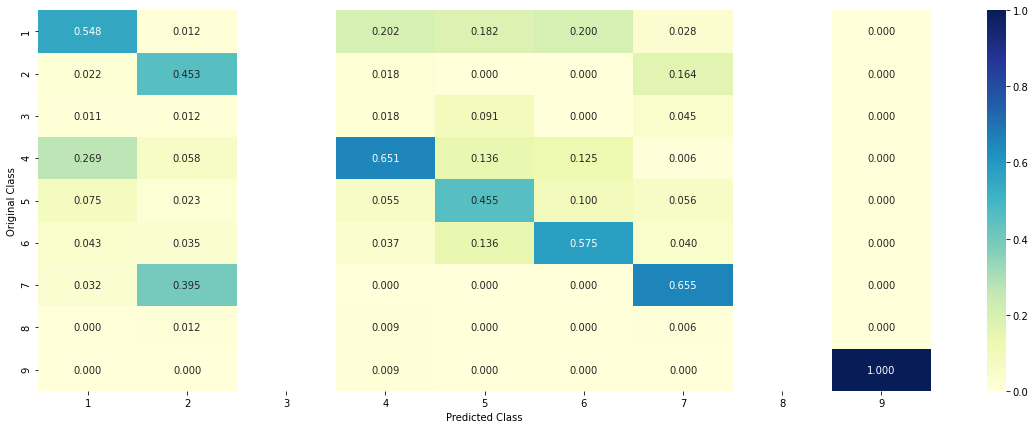

-------------------- Recall matrix (Row sum=1) --------------------


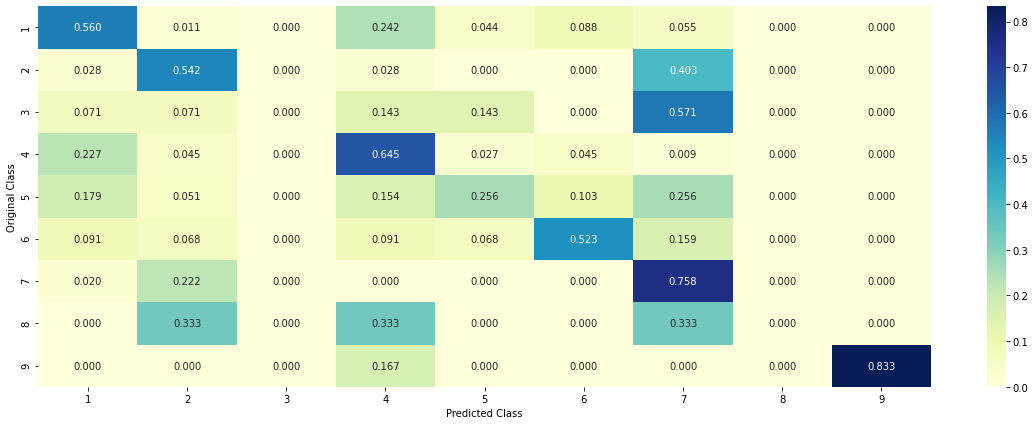

In [68]:
clf = KNeighborsClassifier(n_neighbors = k[best_k])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [69]:
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))

In [70]:
type(predicted_cls)

numpy.ndarray

In [71]:
predicted_cls.shape

(1,)

In [72]:
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), k[best_k])


Predicted Class : 7
Actual Class : 7


In [73]:
neighbors

(array([[0.01036054, 0.01036054, 0.01036054, 0.01036088, 0.01036105,
         0.01036113, 0.01036136, 0.01036139, 0.01036159, 0.01036164,
         0.01036172, 0.01036172, 0.01036176, 0.0103618 , 0.01036188,
         0.01036188, 0.01036199, 0.010362  , 0.01036201, 0.01036224,
         0.01036232, 0.01036232, 0.01036234, 0.01036237, 0.0103626 ,
         0.01036263, 0.01036265, 0.0103627 , 0.0103629 , 0.01036333,
         0.01036337, 0.01036341, 0.01036362, 0.01036372, 0.01036372,
         0.01036382, 0.01036383, 0.01036383, 0.01036389, 0.01036408,
         0.01036417, 0.01036421, 0.01036421, 0.01036424, 0.01036424,
         0.01036424, 0.01036435, 0.01036437, 0.01036437, 0.01036441,
         0.01036442]]),
 array([[ 420, 1343, 2104,  844,   51, 1485,   44,  265,  664,  587,  451,
         1030, 1251,  606, 1135, 1398,  240, 1823, 1021, 1455, 1181, 1670,
          141, 2044,  384,  938,  839,  530, 1000, 2083,  510, 1393, 1180,
          392, 1802, 1041, 1856, 2089,  415, 1643,  714, 2018

In [74]:
print("The ",k[best_k]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

The  51  nearest neighbours of the test points belongs to classes [4 4 7 2 7 7 2 2 7 7 2 2 7 7 7 7 7 5 7 7 2 2 2 7 7 2 7 7 2 7 7 7 7 2 2 7 7
 7 7 2 7 2 7 2 2 7 2 2 6 7 7]
Fequency of nearest points : Counter({7: 29, 2: 18, 4: 2, 5: 1, 6: 1})


In [75]:
test_point_index = 35

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), k[best_k])
print("the k value for knn is",k[best_k],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
the k value for knn is 51 and the nearest neighbours of the test points belongs to classes [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 1 4 1 4 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 4 4 1 1 1 1 1 1 1]
Fequency of nearest points : Counter({1: 44, 4: 7})


## Logistic Regression

With class balancing

for alpha = 1e-06
Log Loss : 1.8308894970074716
for alpha = 1e-05
Log Loss : 1.8308894970074716
for alpha = 0.0001
Log Loss : 1.8008846489445607
for alpha = 0.001
Log Loss : 1.3639136303754889
for alpha = 0.01
Log Loss : 1.3163353666050082
for alpha = 0.1
Log Loss : 1.308616804595153
for alpha = 1
Log Loss : 1.242322010614256
for alpha = 10
Log Loss : 1.2073704475504687
for alpha = 100
Log Loss : 1.3220498038763544


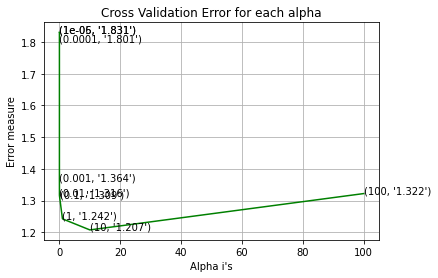

For values of best alpha =  10 The train log loss is: 0.8600361139862154
For values of best alpha =  10 The cross validation log loss is: 1.2073704475504687
For values of best alpha =  10 The test log loss is: 1.1340504704580405


In [76]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.2073704475504687
Number of mis-classified points : 0.43045112781954886
-------------------- Confusion matrix --------------------


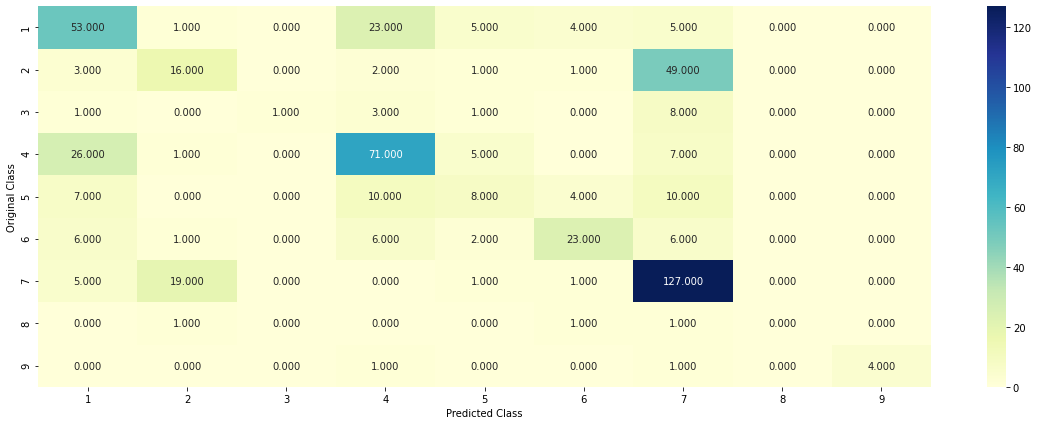

-------------------- Precision matrix (Columm Sum=1) --------------------


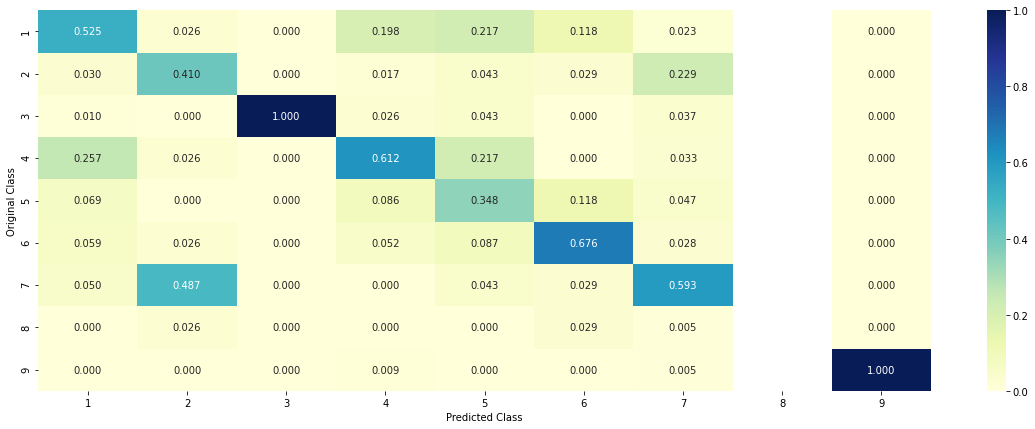

-------------------- Recall matrix (Row sum=1) --------------------


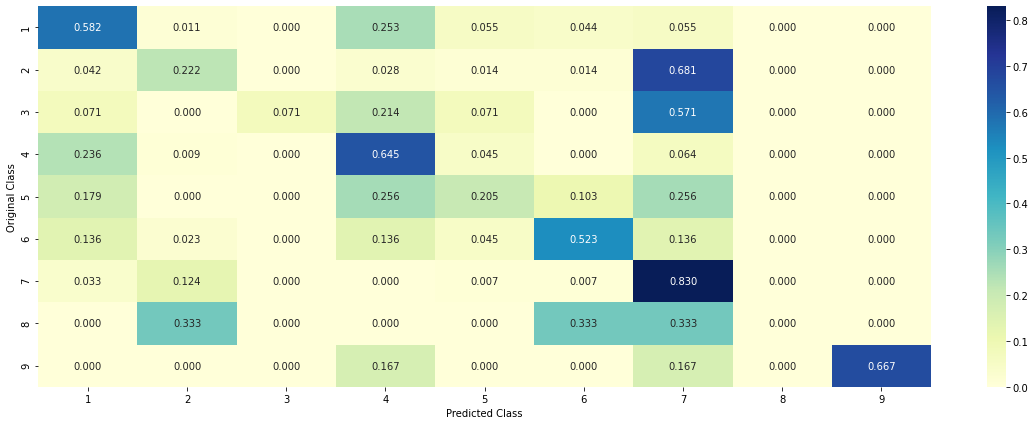

In [77]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [78]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 7
Predicted Class Probabilities: [[0.0165 0.2117 0.0146 0.0584 0.0962 0.0461 0.5461 0.0072 0.0031]]
Actual Class : 7
--------------------------------------------------


Without class balancing

for alpha = 1e-06
Log Loss : 1.8308894970074716
for alpha = 1e-05
Log Loss : 1.8308894970074716
for alpha = 0.0001
Log Loss : 1.8236181632804602
for alpha = 0.001
Log Loss : 1.3260540918571166
for alpha = 0.01
Log Loss : 1.3277937493121066
for alpha = 0.1
Log Loss : 1.3111995631979048
for alpha = 1
Log Loss : 1.2454143954635675


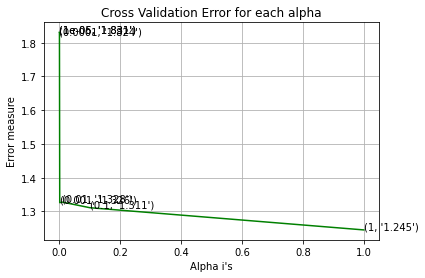

For values of best alpha =  1 The train log loss is: 0.7765158427650323
For values of best alpha =  1 The cross validation log loss is: 1.2454143954635675
For values of best alpha =  1 The test log loss is: 1.1371311752986482


In [83]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.2454143954635675
Number of mis-classified points : 0.41729323308270677
-------------------- Confusion matrix --------------------


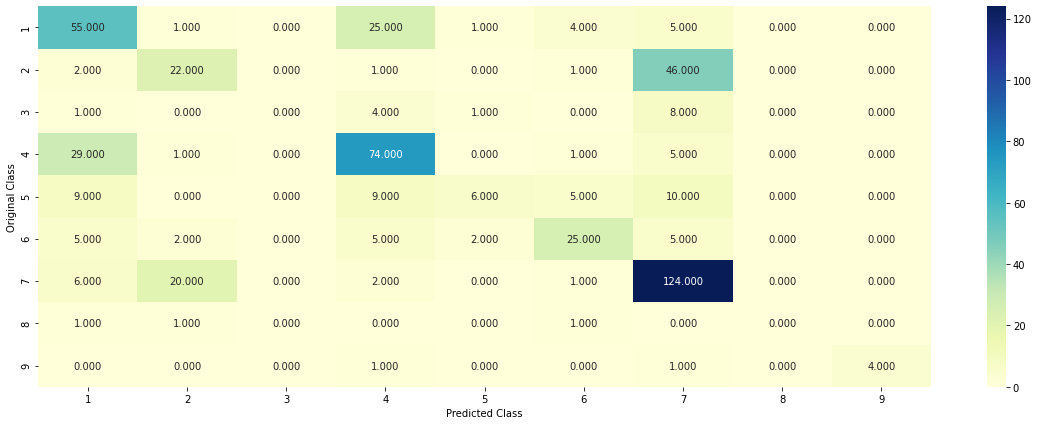

-------------------- Precision matrix (Columm Sum=1) --------------------


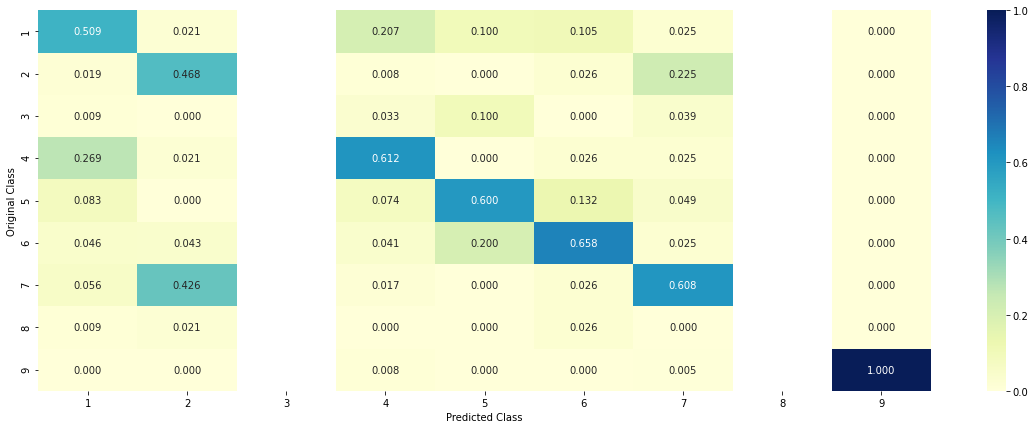

-------------------- Recall matrix (Row sum=1) --------------------


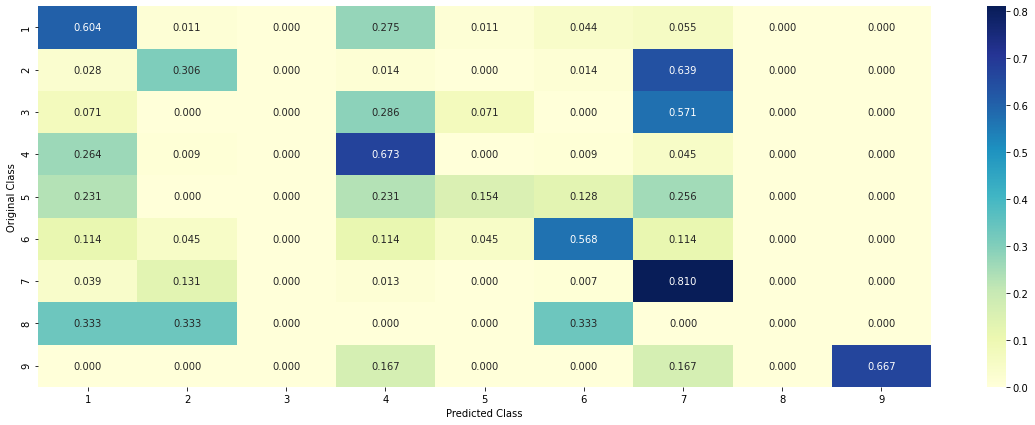

In [84]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [85]:
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.0233 0.1548 0.018  0.274  0.0909 0.0469 0.3818 0.0063 0.0042]]
Actual Class : 7


In [86]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[9.043e-01 2.310e-02 1.800e-03 5.000e-02 3.100e-03 2.700e-03 1.090e-02
  4.000e-03 1.000e-04]]
Actual Class : 1


## Support Vector Machine

for C = 1e-05
Log Loss : 1.8308894970074716
for C = 0.0001
Log Loss : 1.7947448121239638
for C = 0.001
Log Loss : 1.3569209768024006
for C = 0.01
Log Loss : 1.3284078883520443
for C = 0.1
Log Loss : 1.3342914561603216
for C = 1
Log Loss : 1.2896105851445085
for C = 10
Log Loss : 1.2539384088138643
for C = 100
Log Loss : 1.3350351961248195


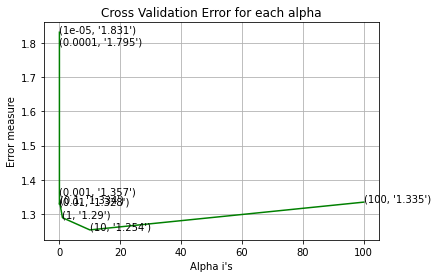

For values of best alpha =  10 The train log loss is: 0.8561107463984506
For values of best alpha =  10 The cross validation log loss is: 1.2539384088138643
For values of best alpha =  10 The test log loss is: 1.1706846213344175


In [87]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.2539384088138643
Number of mis-classified points : 0.42293233082706766
-------------------- Confusion matrix --------------------


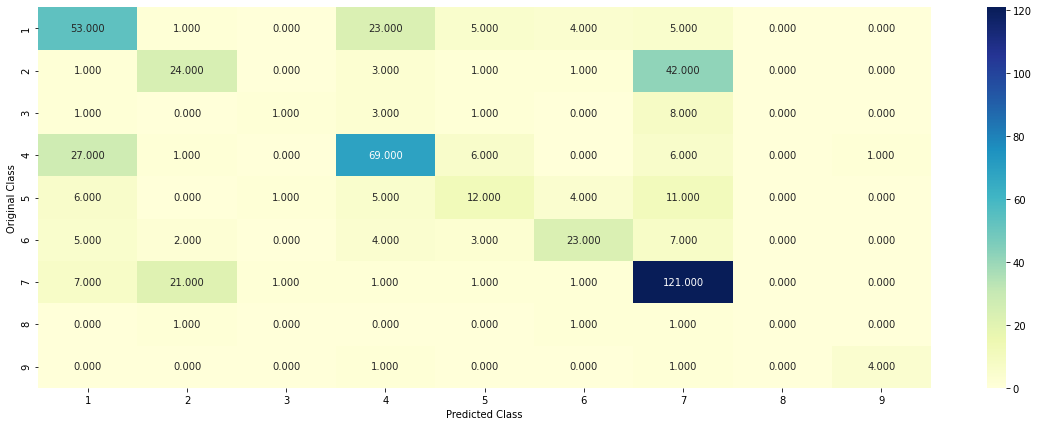

-------------------- Precision matrix (Columm Sum=1) --------------------


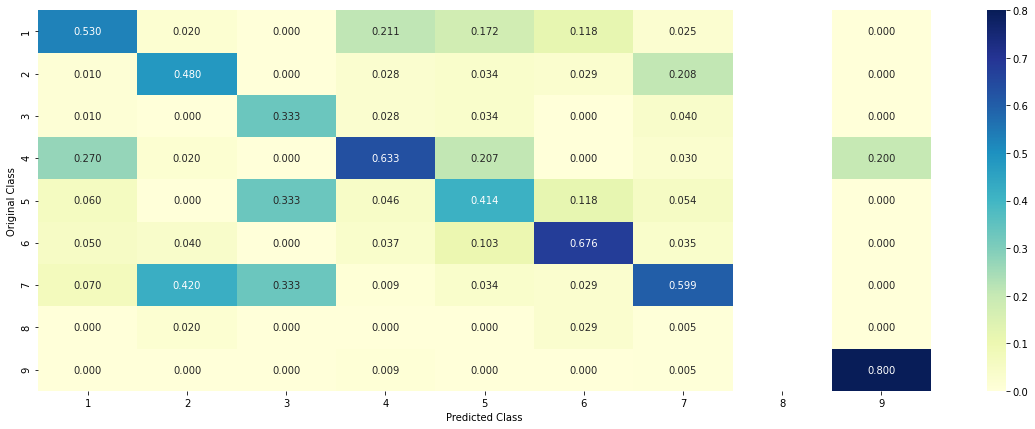

-------------------- Recall matrix (Row sum=1) --------------------


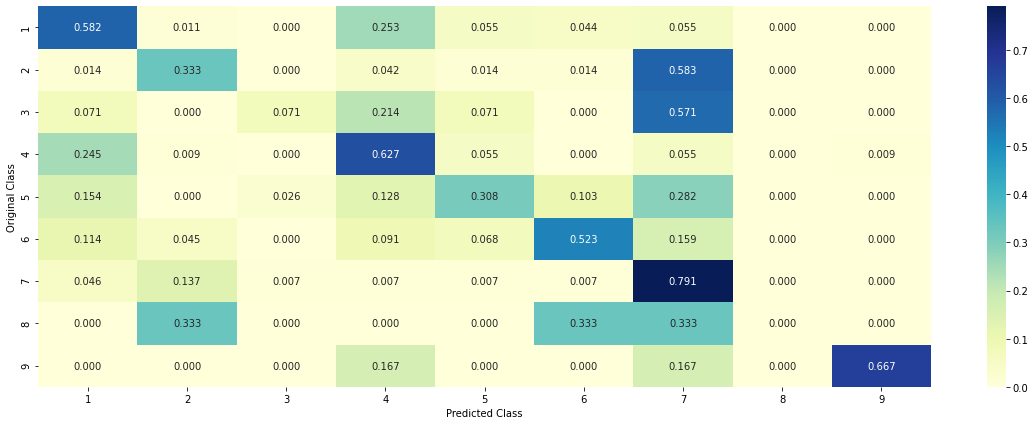

In [88]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [89]:
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.0328 0.1566 0.0188 0.1336 0.0824 0.0671 0.4978 0.0068 0.0041]]
Actual Class : 7


In [90]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[8.154e-01 3.380e-02 1.600e-03 1.288e-01 4.000e-03 3.100e-03 9.800e-03
  3.300e-03 3.000e-04]]
Actual Class : 1


## Random Forest Classifier

Using one hot encoded data

In [91]:
n_estimators = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in n_estimators:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators = i, criterion = 'gini', max_depth = j, random_state = 42, n_jobs = -1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for n_estimators = 100 and max depth =  5
Log Loss : 1.201305177752712
for n_estimators = 100 and max depth =  10
Log Loss : 1.1409909171528643
for n_estimators = 200 and max depth =  5
Log Loss : 1.1922724846842248
for n_estimators = 200 and max depth =  10
Log Loss : 1.1358309331607668
for n_estimators = 500 and max depth =  5
Log Loss : 1.1911413020835333
for n_estimators = 500 and max depth =  10
Log Loss : 1.1331401246144304
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1921739089341525
for n_estimators = 1000 and max depth =  10
Log Loss : 1.130619151644757
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1901371429712577
for n_estimators = 2000 and max depth =  10
Log Loss : 1.128989671524451


In [92]:
best_alpha = np.argmin(cv_log_error_array)
print(best_alpha)

9


In [93]:
cv_log_error_array

[1.201305177752712,
 1.1409909171528643,
 1.1922724846842248,
 1.1358309331607668,
 1.1911413020835333,
 1.1331401246144304,
 1.1921739089341525,
 1.130619151644757,
 1.1901371429712577,
 1.128989671524451]

In [95]:
clf = RandomForestClassifier(n_estimators = n_estimators[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha % 2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=10,
                                                             n_estimators=2000,
                                                             n_jobs=-1,
                                                             random_state=42))

In [96]:
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', n_estimators[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', n_estimators[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', n_estimators[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  2000 The train log loss is: 0.6818294168457935
For values of best estimator =  2000 The cross validation log loss is: 1.128989671524451
For values of best estimator =  2000 The test log loss is: 1.0423467307415544


Log loss : 1.128989671524451
Number of mis-classified points : 0.39097744360902253
-------------------- Confusion matrix --------------------


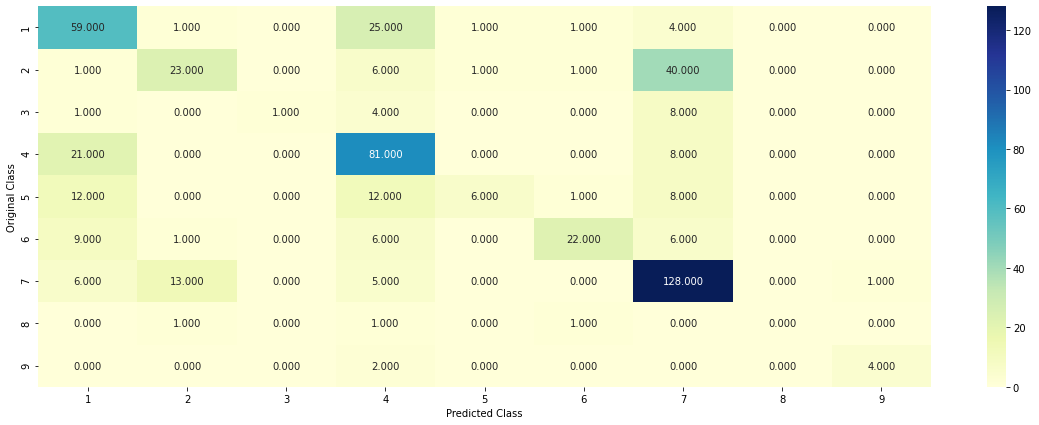

-------------------- Precision matrix (Columm Sum=1) --------------------


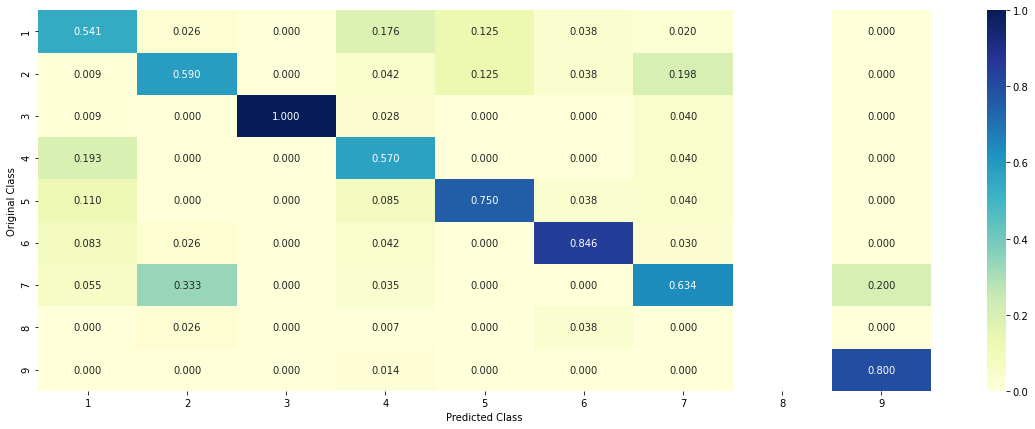

-------------------- Recall matrix (Row sum=1) --------------------


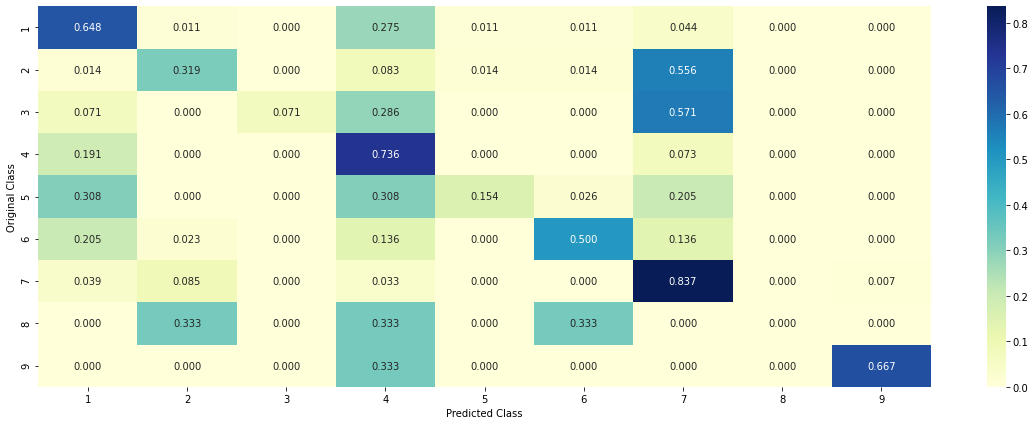

In [98]:
clf = RandomForestClassifier(n_estimators = n_estimators[int(best_alpha/2)], criterion = 'gini', max_depth = max_depth[int(best_alpha%2)], random_state = 42, n_jobs = -1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [99]:
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.0411 0.1305 0.0234 0.1197 0.0446 0.0364 0.5947 0.0048 0.0049]]
Actual Class : 7


In [100]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[0.5148 0.0427 0.0222 0.241  0.0515 0.0464 0.0682 0.0067 0.0066]]
Actual Class : 1


With Response Coding


In [103]:
n_estimators = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in n_estimators:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators = i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators = n_estimators[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best n_estimators = ', n_estimators[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best n_estimators = ', n_estimators[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best n_estimators = ', n_estimators[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.153739406278175
for n_estimators = 10 and max depth =  3
Log Loss : 1.8511510311748083
for n_estimators = 10 and max depth =  5
Log Loss : 1.6741941781586989
for n_estimators = 10 and max depth =  10
Log Loss : 2.106414883366916
for n_estimators = 50 and max depth =  2
Log Loss : 1.8968308021997744
for n_estimators = 50 and max depth =  3
Log Loss : 1.6591123264966563
for n_estimators = 50 and max depth =  5
Log Loss : 1.5666884335459081
for n_estimators = 50 and max depth =  10
Log Loss : 1.8504755128732615
for n_estimators = 100 and max depth =  2
Log Loss : 1.8961246446792273
for n_estimators = 100 and max depth =  3
Log Loss : 1.4967143121544724
for n_estimators = 100 and max depth =  5
Log Loss : 1.4288449296793646
for n_estimators = 100 and max depth =  10
Log Loss : 1.7679543045976522
for n_estimators = 200 and max depth =  2
Log Loss : 1.7970449300843376
for n_estimators = 200 and max depth =  3
Log Loss : 1.5104004278325467

Log loss : 1.4155392719561408
Number of mis-classified points : 0.5093984962406015
-------------------- Confusion matrix --------------------


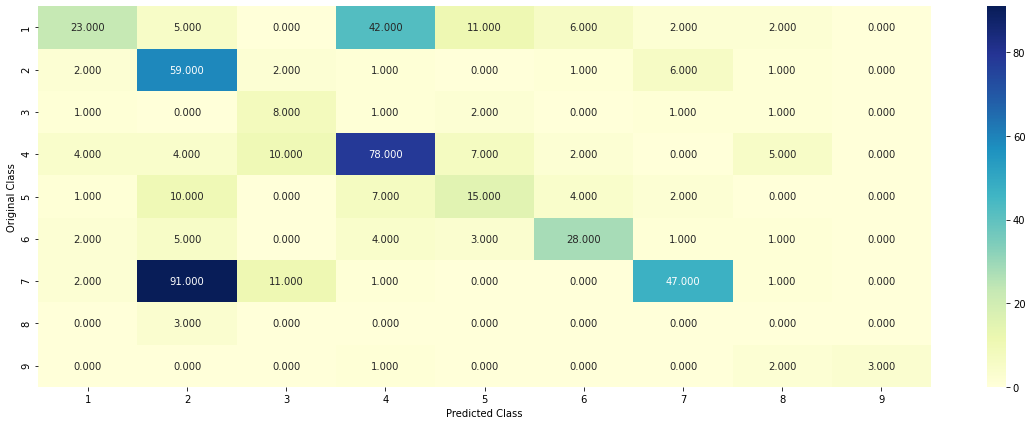

-------------------- Precision matrix (Columm Sum=1) --------------------


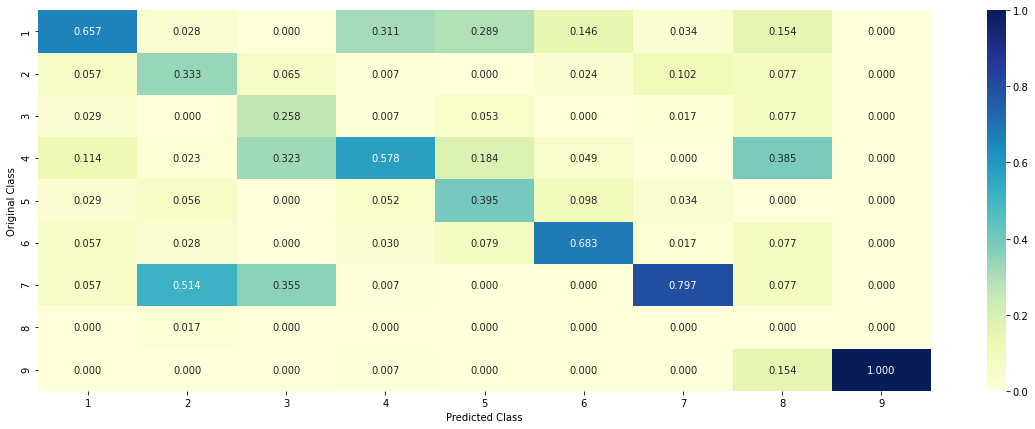

-------------------- Recall matrix (Row sum=1) --------------------


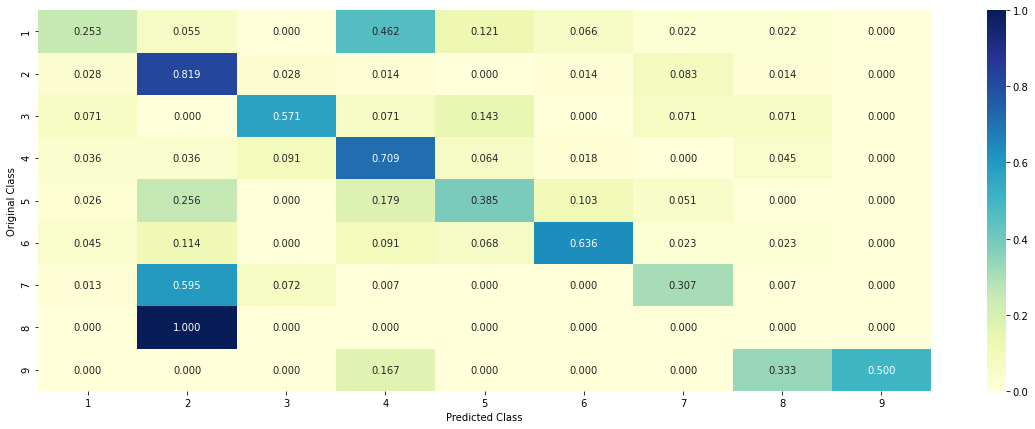

In [104]:
clf = RandomForestClassifier(max_depth = max_depth[int(best_alpha % 4)], n_estimators = n_estimators[int(best_alpha/4)], criterion = 'gini', max_features ='auto',random_state = 42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [105]:
test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.019  0.3374 0.1264 0.054  0.0575 0.1154 0.2499 0.0224 0.0182]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature


In [106]:
test_point_index = 100
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 1
Predicted Class Probabilities: [[0.956  0.003  0.0017 0.0271 0.002  0.0038 0.0018 0.0019 0.0027]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature


## Stack The Models